# Simulation and inference of Poisson RGG (in stan)

$$P(G|D, \theta) = \prod_{i<j} \frac{(\mathcal{F}(D_{ij}, \theta))^{A_{ij}}}{A_{ij}!} \exp(-\mathcal{F}(D_{ij}, \theta))$$

In [83]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import sys
sys.path.append('../../utils')

In [3]:
from graphs import get_independent_components_rgg, make_inter_vertex_distances, poissonian_random_geometric_graph
from plot import plot_multigraph
from networkx.linalg.graphmatrix import adjacency_matrix
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import math

import nest_asyncio
nest_asyncio.apply()
import stan

In [82]:
import arviz as az

In [4]:
SEED = 42
n = 10
dim = 2

In [5]:
kr_exp = 2
kc_exp = 1
exponential_kernel = lambda dist: kc_exp*math.exp(-kr_exp * dist)

In [6]:
r = np.random.RandomState(SEED)
G_poisson = poissonian_random_geometric_graph(n, 1000, r, p_dist=exponential_kernel)

In [7]:
nodes_pos = G_poisson.nodes(data="pos")

In [8]:
adj = adjacency_matrix(G_poisson)
adj = adj.toarray()

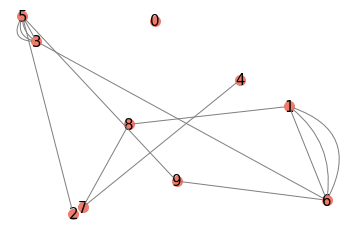

In [9]:
ax = plot_multigraph(G_poisson)

In [10]:
distances = make_inter_vertex_distances(G_poisson)

In [11]:
distances_filter,  adj_filter = get_independent_components_rgg(G_poisson, distances)

## Inference

In [70]:
def make_poisson_rgg_model(n_dof_adj):
    model = f"""
    data {{
        vector[{n_dof_adj}] distances_filter;
        int<lower=0> adj_filter [{n_dof_adj}];
    }}
    parameters {{
        real<lower=0> kr;
        real<lower=0> kc;
    }}
    transformed parameters {{
        vector[{n_dof_adj}] conn_kernel;
        conn_kernel = kc * exp(-kr * distances_filter);
    }}
    model {{
        kc ~ exponential(0.1);
        kr ~ exponential(0.1);
        adj_filter ~ poisson(conn_kernel);
    }}
    """
    return model

In [71]:
poisson_rgg_model = make_poisson_rgg_model(len(adj_filter))

In [72]:
poisson_rgg_data = {'distances_filter': distances_filter, 'adj_filter': adj_filter}

In [73]:
posterior = stan.build(poisson_rgg_model, data=poisson_rgg_data, random_seed=SEED)

Building...



Building: 17.1s, done.

In [74]:
fit = posterior.sample(num_chains=4, num_samples=1000)

Sampling:   0%
Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 4.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.44 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.12 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.14 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.12 seconds.
  Adjust your expectations accordingly!


In [77]:
inferred = arviz.from_pystan(fit)

In [90]:
az.summary(inferred, var_names = ['kr', 'kc'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
kr,2.632,1.073,0.611,4.605,0.032,0.023,1095.0,1233.0,1.0
kc,1.269,0.661,0.325,2.457,0.022,0.016,971.0,1087.0,1.0


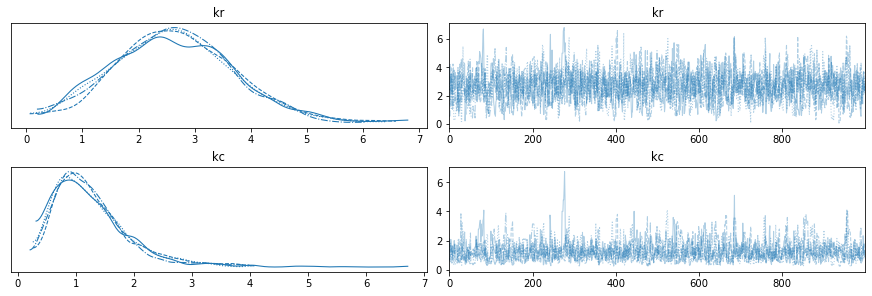

In [99]:
az.plot_trace(inferred, var_names = ['kr', 'kc']);

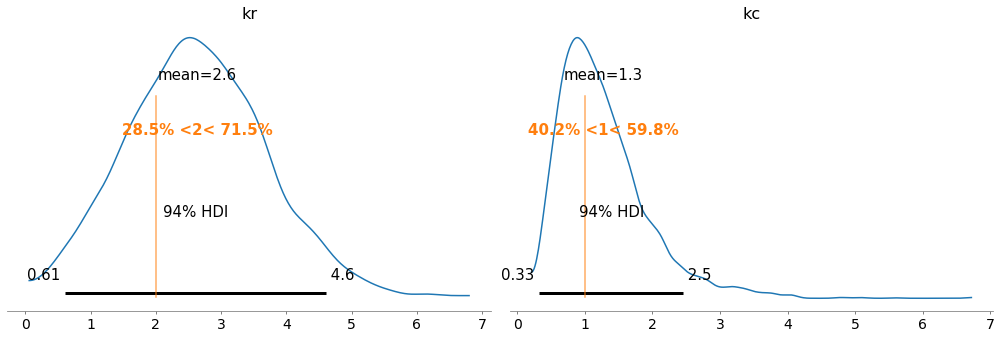

In [100]:
az.plot_posterior(inferred, var_names = ['kr', 'kc'], ref_val = {'kr':[{'ref_val': kr_exp}], 'kc': [{'ref_val':kc_exp}]});